In [60]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

In [61]:
data_full = pd.read_csv('./covtype.data', header=None)

In [62]:
#Randomly sample the data to reduce the size of dataset due to computation difficulty
RandInd = np.random.choice(len(data_full),6000)
data = data_full.iloc[RandInd,:].reset_index().drop(['index'], axis = 1)

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [63]:
#Splitting data into training and testing and keeping testing data aside
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)

In [64]:
len(X_train)

4500

In [65]:
len(X_test)

1500

In [66]:
#PreProcessing(Data Compression)
pca = PCA()
pca.fit(X_train)
VarianceRatio = pca.explained_variance_ratio_

In [67]:
#Finding number of principal components
#Retaining 99% of total variance 
TotVar = 0 
for idx, Var in enumerate(VarianceRatio):
    TotVar += Var 
    if(TotVar>=0.99): 
        break 
print('Total Retained Variance: {}'.format(TotVar)) 
print('Number of principal components {}'.format(idx))

Total Retained Variance: 0.9961101535850962
Number of principal components 3


In [68]:
#Again fitting pca for 3 principal components
pcaRed = PCA(n_components = 5,whiten= True)
pcaRed.fit(X_train)
#Compressing training and testing data using fitted data
X_train_pca = pcaRed.transform(X_train)
X_test_pca = pcaRed.transform(X_test)

In [69]:
X_train_pca

array([[ 1.17531416,  3.8110304 , -1.45908488, -0.32087906, -0.71604527],
       [-0.93928756, -0.139585  ,  0.74461368,  0.52107743, -0.81614648],
       [-0.90295393, -0.42567704,  0.9387104 , -1.10868111, -1.22302542],
       ...,
       [ 1.49383977, -1.3629722 , -0.42606902, -0.93532508, -0.52322288],
       [-0.85951113, -0.18892365, -0.90788556,  0.3291457 ,  1.64327764],
       [-0.96671023, -0.36097536,  0.92030465, -0.74703516,  0.48136681]])

In [70]:
#Concatenated train and test data
cov_type_data = np.concatenate((X_train_pca,y_train.values.reshape(-1,1)), axis=1)
test_cov_type_data = np.concatenate((X_test_pca,y_test.values.reshape(-1,1)), axis=1)

In [71]:
np.savetxt('cov_type_data.txt',cov_type_data,delimiter=',')
np.savetxt('test_cov_type_data.txt',test_cov_type_data,delimiter=',')

In [41]:
len(np.unique(data[:,-1]))

7

In [86]:
#Grid Search CV on random subset of data without pca
#3 fold cross validation 

clf = DecisionTreeClassifier(criterion = 'gini')
parameter_grid = {
                 'criterion' : ['gini', 'entropy'],
                 'max_depth': [5,10,15,20,25,30,35,50,75,100],
                 'min_samples_split': [2, 5, 10, 20,50, 80, 150,200,300,400,500]
                 }
grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=3)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.69225
Best parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 5}


In [87]:
#Grid Search CV on random subset of data with pca
#3 fold cross validation 

clf = DecisionTreeClassifier(criterion = 'gini')
parameter_grid = {
                 'criterion' : ['gini', 'entropy'],
                 'max_depth': [1, 2, 5,10,15,20,25,30,35,50,75,100],
                 'min_samples_split': [2, 5, 10, 20,50, 80, 150,200,300,400,500]
                 }
grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=3)
grid_search.fit(X_train_pca, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.61575
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 80}


In [91]:
# Now training using random subset of training dataset
t0 = time.time()
clf = DecisionTreeClassifier(criterion =  'gini', max_depth = 15, min_samples_split =  5)
RValidScore = np.mean(cross_val_score(clf,X_train, y_train, cv=3))
t1 = time.time()
print('Cross-validation accuracy is : {}'.format(RValidScore))
print('Total training and cross-validation accuracy calculation time: {}'.format(np.abs(t1-t0)))

Cross-validation accuracy is : 0.6864813915712119
Total training and cross-validation accuracy calculation time: 0.08989357948303223


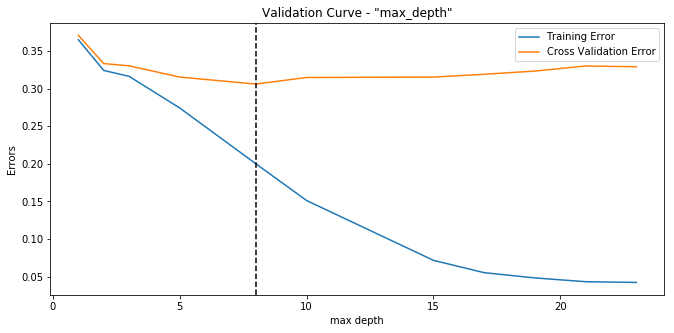

maximum depth for minimum Cross validation error: 8


In [92]:
#Validation curve for maximum depth
clf = DecisionTreeClassifier(criterion =  'gini',min_samples_split =5)
param_range = [1,2,3,5,8,10,15,17,19,21,23]
train_scores, test_scores = validation_curve(clf, X_train, y_train, param_name="max_depth", param_range=param_range,cv=3, scoring="accuracy", n_jobs=1)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.figure(figsize= (11,5))
plt.plot(param_range,1 -train_score_mean)
plt.plot(param_range,1 -test_score_mean)
plt.axvline(x=param_range[np.argmin(1 - test_score_mean)],color='k', linestyle='--')
plt.xlabel('max depth')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.title('Validation Curve - "max_depth"')
plt.show()
print('maximum depth for minimum Cross validation error: {}'.format(param_range[np.argmin(1-test_score_mean)]))

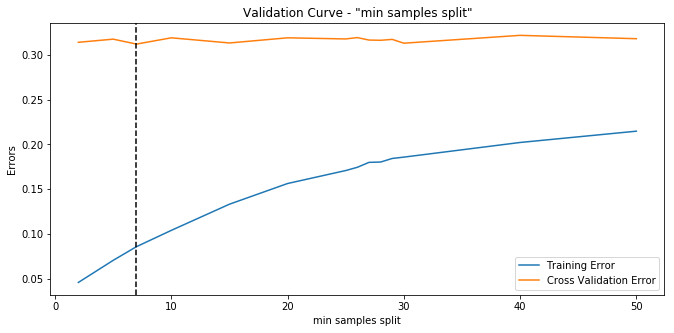

min_sample_split for minimum Cross validation error: 7


In [98]:
#Validation curve for min samples split
clf = DecisionTreeClassifier(criterion =  'gini',max_depth =15)
param_range = [2,5,7,10,15,20,25,26,27,28,29,30, 40, 50]
train_scores, test_scores = validation_curve(clf, X_train, y_train, param_name="min_samples_split", param_range = param_range,cv=3, scoring="accuracy", n_jobs=1)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.figure(figsize= (11,5))
plt.plot(param_range,1 -train_score_mean)
plt.plot(param_range,1 -test_score_mean)
plt.axvline(x=param_range[np.argmin(1 - test_score_mean)],color='k', linestyle='--')
plt.xlabel('min samples split')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.title('Validation Curve - "min samples split"')
plt.show()
print('min_sample_split for minimum Cross validation error: {}'.format(param_range[np.argmin(1-test_score_mean)]))

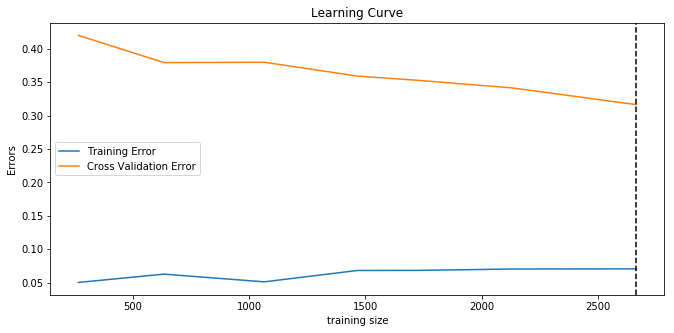

In [99]:
#Learning Curve 
clf = DecisionTreeClassifier(criterion =  'gini', max_depth =  15, min_samples_split =  5)
train_sizes, train_scores, test_scores = learning_curve(clf,X_train,y_train,train_sizes = np.array([0.1, 0.238, 0.4, 0.55, 0.65, 0.8, 1]),cv = 3)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.figure(figsize= (11,5))
plt.plot(train_sizes,1 -train_score_mean)
plt.plot(train_sizes,1 -test_score_mean)
plt.xlabel('training size')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.axvline(x=train_sizes[np.argmin(1 - np.array(test_score_mean))],color='k', linestyle='--')
plt.title('Learning Curve')
plt.show()

In [125]:
#Decision Tree
t1 = time.time()
RandInd = np.random.choice(len(X_train),3000)
Rtrain = X_train.iloc[RandInd,:]
Rlabels = y_train.iloc[RandInd]
clf1 = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_split =5)
# clf1.fit(Rtrain,Rlabels)
clf1.fit(X_train,y_train)
y_pred1 = clf1.predict(X_test)
t2 = time.time()
print('Running time: {}'.format(t2-t1))

Running time: 0.04492616653442383


In [126]:
t1 = time.time()
#Final accuracy score for Decision tree with pruning
print("Final accuracy score for Decision tree: {}".format(accuracy_score(y_test, y_pred1)))
t2 = time.time()
print('Running time: {}'.format(t2-t1))

Final accuracy score for Decision tree: 0.659
Running time: 0.0030167102813720703


# SVM

In [88]:
#Grid Search CV on random subset of data with pca
#3 fold cross validation

clf = SVC(C = 100, kernel = 'rbf', gamma = 0.01)
parameter_grid = {
                 'C' : [0.1, 1,5, 7, 10, 15],
                 'gamma': [0.05,0.01,0.1,0.5,1,10],
                 'kernel': ['rbf']
                 }
grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv =3)
grid_search.fit(X_train_pca, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.65825
Best parameters: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}


In [90]:
#Grid Search CV on random subset of data without pca
#3 fold cross validation

clf = SVC(C = 100, kernel = 'rbf', gamma = 0.01)
parameter_grid = {
                 'C' : [0.1, 1,5, 7, 10, 15],
                 'gamma': [0.05,0.01,0.1,0.5,1,10],
                 'kernel': ['rbf']
                 }
grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv =3)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.4915
Best parameters: {'C': 1, 'gamma': 0.05, 'kernel': 'rbf'}


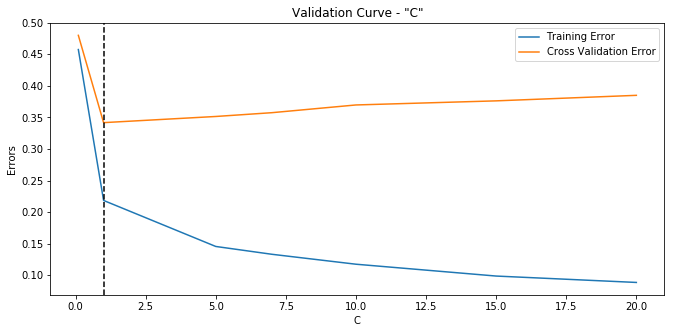

C for min cross validation error: 1


In [130]:
#Validation curve for C
clf = SVC(C = 1, gamma = 10, kernel = 'rbf')
param_range = [0.1, 1,5, 7, 10, 15, 20]
train_scores, test_scores = validation_curve(clf, X_train_pca, y_train, param_name="C", param_range=param_range,cv=3, scoring="accuracy", n_jobs=1)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.figure(figsize= (11,5))
plt.plot(param_range,1 -train_score_mean)
plt.plot(param_range,1 -test_score_mean)
plt.axvline(x=param_range[np.argmin(1 - test_score_mean)],color='k', linestyle='--')
plt.xlabel('C')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.title('Validation Curve - "C"')
plt.show()
print('C for min cross validation error: {}'.format(param_range[np.argmin(1-test_score_mean)]))

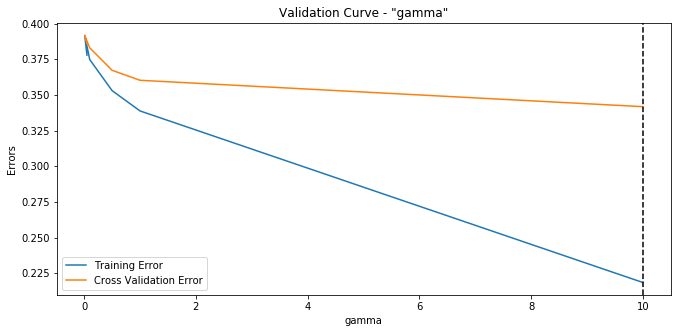

gamma for min cross validation error: 10


In [131]:
#Validation curve for gamma
clf = SVC(C = 1, kernel = 'rbf')
param_range = [0.05,0.01,0.1,0.5,1,10]
train_scores, test_scores = validation_curve(clf, X_train_pca, y_train, param_name="gamma", param_range=param_range,cv=3, scoring="accuracy", n_jobs=1)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.figure(figsize= (11,5))
plt.plot(param_range,1 -train_score_mean)
plt.plot(param_range,1 -test_score_mean)
plt.axvline(x=param_range[np.argmin(1 - test_score_mean)],color='k', linestyle='--')
plt.xlabel('gamma')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.title('Validation Curve - "gamma"')
plt.show()
print('gamma for min cross validation error: {}'.format(param_range[np.argmin(1-test_score_mean)]))

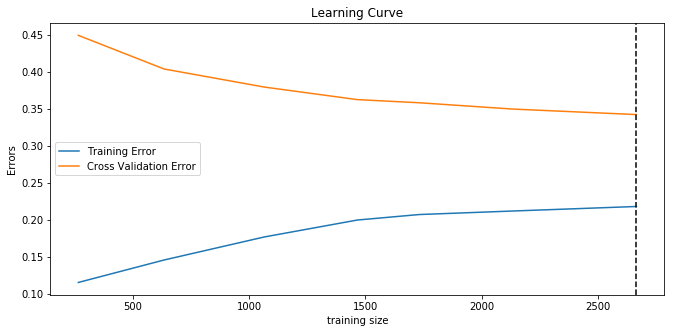

In [132]:
#Learning Curve 
clf = SVC(C = 1, kernel = 'rbf', gamma = 10)
train_sizes, train_scores, test_scores = learning_curve(clf,X_train_pca,y_train,train_sizes = np.array([0.1, 0.238, 0.4, 0.55, 0.65, 0.8, 1]),cv = 3)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.figure(figsize= (11,5))
plt.plot(train_sizes,1 -train_score_mean)
plt.plot(train_sizes,1 -test_score_mean)
plt.xlabel('training size')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.axvline(x=train_sizes[np.argmin(1 - np.array(test_score_mean))],color='k', linestyle='--')
plt.title('Learning Curve')
plt.show()

In [144]:
#SVM
t1 = time.time()
RandInd = np.random.choice(len(X_train),3000)
Rtrain = X_train_pca[RandInd,:]
Rlabels = y_train.iloc[RandInd]
clf2 = SVC(C = 1, kernel = 'rbf', gamma = 10)
# clf2.fit(Rtrain,Rlabels)
clf2.fit(X_train_pca, y_train)
y_pred2 = clf2.predict(X_test_pca)
t2 = time.time()
print('Running time: {}'.format(t2-t1))

Running time: 1.0426671504974365


In [145]:
t1 = time.time()
print('Final accuracy score for SVM : {}'.format(accuracy_score(y_test,y_pred2)))
t2 = time.time()
print('Running time: {}'.format(t2-t1))

Final accuracy score for SVM : 0.642
Running time: 0.0018200874328613281


In [146]:
#Boosting

In [148]:
#Grid Search CV on the data without pca
#3 fold cross validation

clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion =  'gini', max_depth =  15, min_samples_split =  5), learning_rate = 0.8, n_estimators=20)
parameter_grid = {
                 'learning_rate' : [0.1,0.3,0.5,0.7,0.9,1],
                 'n_estimators': [100,200, 300, 400, 500],
                 }
grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=3)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.76025
Best parameters: {'learning_rate': 1, 'n_estimators': 500}


In [149]:
#Grid Search CV on the data with pca
#3 fold cross validation

clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion =  'gini', max_depth =  80, min_samples_split =  10), learning_rate = 0.8, n_estimators=20)
parameter_grid = {
                 'learning_rate' : [0.1,0.3,0.5,0.7,0.9,1],
                 'n_estimators': [1,10,20,30,40,50,70,100,200],
                 }
grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=3)
grid_search.fit(X_train_pca, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.6585
Best parameters: {'learning_rate': 0.7, 'n_estimators': 200}


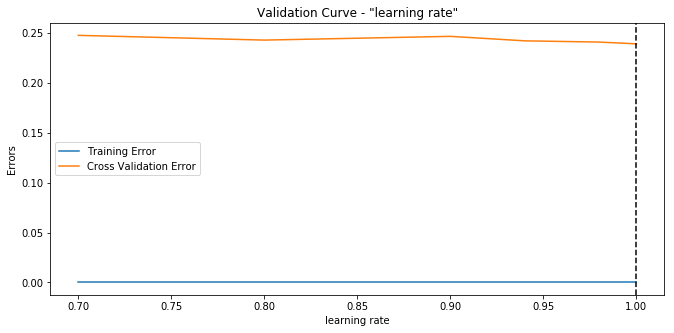

learning rate for min cross validation error: 1


In [150]:
#Validation curve for learning rate
clf3 =AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion =  'gini', max_depth =  15, min_samples_split =  5), learning_rate = 0.8, n_estimators=400)
param_range = [0.7,0.8,0.9,0.94,0.98,1]
train_scores, test_scores = validation_curve(clf3, X_train, y_train, param_name = "learning_rate", param_range = param_range, cv = 3, scoring = "accuracy", n_jobs=1)
train_score_mean = np.mean(train_scores, axis=1)
test_score_mean = np.mean(test_scores, axis=1)
plt.figure(figsize = (11,5))
plt.plot(param_range,1 - train_score_mean)
plt.plot(param_range,1 - test_score_mean)
plt.axvline(x = param_range[np.argmin(1 - test_score_mean)],color='k', linestyle='--')
plt.xlabel('learning rate')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.title('Validation Curve - "learning rate"')
plt.show()
print('learning rate for min cross validation error: {}'.format(param_range[np.argmin(1-test_score_mean)]))

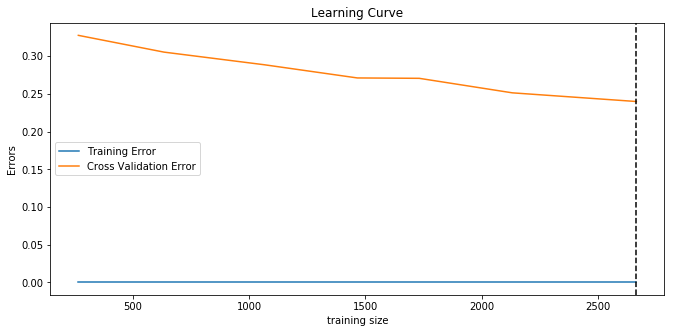

In [33]:
#Learning Curve 
clf =AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion =  'gini', max_depth =  15, min_samples_split =  5), learning_rate = 1, n_estimators=500)
train_sizes, train_scores, test_scores = learning_curve(clf,X_train,y_train,train_sizes = np.array([0.1, 0.238, 0.4, 0.55, 0.65, 0.8, 1]),cv = 3)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.figure(figsize= (11,5))
plt.plot(train_sizes,1 -train_score_mean)
plt.plot(train_sizes,1 -test_score_mean)
plt.xlabel('training size')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.axvline(x=train_sizes[np.argmin(1 - np.array(test_score_mean))],color='k', linestyle='--')
plt.title('Learning Curve')
plt.show()

In [160]:
t1 = time.time()
RandInd = np.random.choice(len(X_train),3000)
Rtrain = X_train.iloc[RandInd,:]
Rlabels = y_train.iloc[RandInd]
clf3 = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion =  'gini', max_depth =  15, min_samples_split =  5), learning_rate = 1, n_estimators=400)
# clf3.fit(Rtrain,Rlabels)
clf3.fit(X_train, y_train)
y_pred3 = clf3.predict(X_test)
t2 = time.time()
print('Runing time: {}'.format(t2-t1))

Runing time: 12.028752326965332


In [161]:
t1 = time.time()
print('Final accuracy score for Boosted Decision Tree : {}'.format(accuracy_score(y_test,y_pred3)))
t2 = time.time()
print('Runing time: {}'.format(t2-t1))

Final accuracy score for Boosted Decision Tree : 0.762
Runing time: 0.0007696151733398438


In [162]:
#KNN

In [166]:
#Grid Search CV on data with pca
#3 fold cross validation

clf4 = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', algorithm = 'auto')
parameter_grid = {
                 'n_neighbors' : [5, 10,20,25,30,35,40, 50, 70,100],
                 'weights': ['uniform', 'distance'],
                 }
grid_search = GridSearchCV(clf4, param_grid=parameter_grid, cv=3)
grid_search.fit(X_train_pca, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.66625
Best parameters: {'n_neighbors': 30, 'weights': 'distance'}


In [171]:
#Grid Search CV on data without pca
#3 fold cross validation

clf4 = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', algorithm = 'auto')
parameter_grid = {
                 'n_neighbors' : [1, 2,3,5,7,9, 10,15,19, 50, 70,100],
                 'weights': ['uniform', 'distance'],
                 }
grid_search = GridSearchCV(clf4, param_grid=parameter_grid, cv=3)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.69775
Best parameters: {'n_neighbors': 9, 'weights': 'distance'}


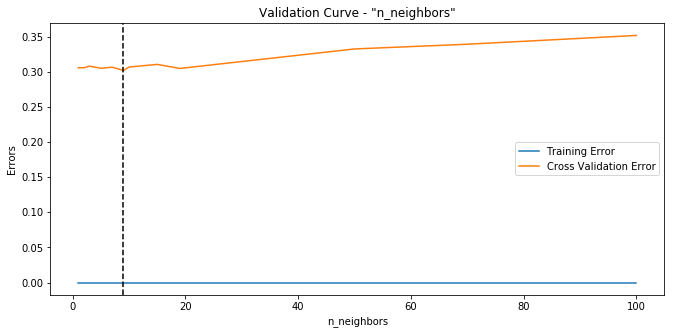

n_neighbors for min cross validation error: 9


In [172]:
#Validation curve for n_neighbors
clf4 = KNeighborsClassifier(n_neighbors = 120, weights = 'distance', algorithm = 'auto')
param_range = [1, 2,3,5,7,9, 10,15,19, 50, 70,100]
train_scores, test_scores = validation_curve(clf4, X_train, y_train, param_name = "n_neighbors", param_range = param_range, cv = 3, scoring = "accuracy", n_jobs=1)
train_score_mean = np.mean(train_scores, axis=1)
test_score_mean = np.mean(test_scores, axis=1)
plt.figure(figsize = (11,5))
plt.plot(param_range,1 - train_score_mean)
plt.plot(param_range,1 - test_score_mean)
plt.axvline(x = param_range[np.argmin(1 - test_score_mean)],color='k', linestyle='--')
plt.xlabel('n_neighbors')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.title('Validation Curve - "n_neighbors"')
plt.show()
print('n_neighbors for min cross validation error: {}'.format(param_range[np.argmin(1-test_score_mean)]))

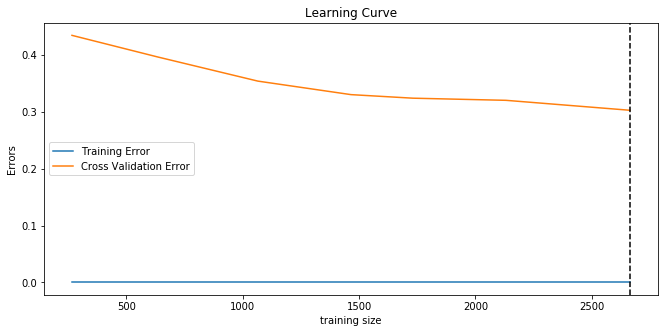

In [32]:
#Learning Curve 
clf = KNeighborsClassifier(n_neighbors = 9, weights = 'distance', algorithm = 'auto')
train_sizes, train_scores, test_scores = learning_curve(clf,X_train,y_train,train_sizes = np.array([0.1, 0.238, 0.4, 0.55, 0.65, 0.8, 1]),cv = 3)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.figure(figsize= (11,5))
plt.plot(train_sizes,1 -train_score_mean)
plt.plot(train_sizes,1 -test_score_mean)
plt.xlabel('training size')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.axvline(x=train_sizes[np.argmin(1 - np.array(test_score_mean))],color='k', linestyle='--')
plt.title('Learning Curve')
plt.show()

In [182]:
t1 = time.time()
RandInd = np.random.choice(len(X_train),3000)
Rtrain = X_train.iloc[RandInd,:]
Rlabels = y_train.iloc[RandInd]
clf4 = KNeighborsClassifier(n_neighbors = 9,weights = 'distance', algorithm = 'auto')
clf4.fit(X_train,y_train)
# clf4.fit(Rtrain,Rlabels)
y_pred4 = clf4.predict(X_test)
t2 = time.time()
print('Running time: {}'.format(t2-t1))

Running time: 0.05818057060241699


In [183]:
t1 = time.time()
print('Final accuracy score for K nearest neighbours : {}'.format(accuracy_score(y_test,y_pred4)))
t2 = time.time()
print('Running time: {}'.format(t2-t1))

Final accuracy score for K nearest neighbours : 0.695
Running time: 0.0018291473388671875


In [184]:
#Neural networks

In [12]:
#Grid Search CV on data without pca
#3 fold cross validation

clf5 = MLPClassifier(hidden_layer_sizes=(54,1,2),max_iter=1000)
parameter_grid = {
                 'hidden_layer_sizes' : [(54,1,2),(54,2,2),(54,3,2),(54,5,2),(54,7,2),(54,8,2),(54,11,2)],
                 'max_iter': [100, 200, 300, 500, 700, 900, 1000, 1200, 1400, 1600, 2000]
                 }
grid_search = GridSearchCV(clf5, param_grid=parameter_grid, cv=3)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.55775
Best parameters: {'hidden_layer_sizes': (54, 5, 2), 'max_iter': 500}


In [30]:
#Grid Search CV on data with pca
#3 fold cross validation

clf5 = MLPClassifier(hidden_layer_sizes=(3,1,2),max_iter=1000)
parameter_grid = {
                 'hidden_layer_sizes' : [(3,1,2),(3,2,2),(3,3,2),(3,5,2),(3,7,2),(3,8,2),(3,11,2)],
                 'max_iter': [100, 200, 300, 500, 700, 900, 1000, 1200, 1400, 1600, 2000]
                 }
grid_search = GridSearchCV(clf5, param_grid=parameter_grid, cv=3)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

/home/siddharth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/siddharth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/siddharth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/siddharth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn'

Best score: 0.55425
Best parameters: {'hidden_layer_sizes': (3, 2, 2), 'max_iter': 2000}


/home/siddharth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/siddharth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/siddharth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/siddharth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn'

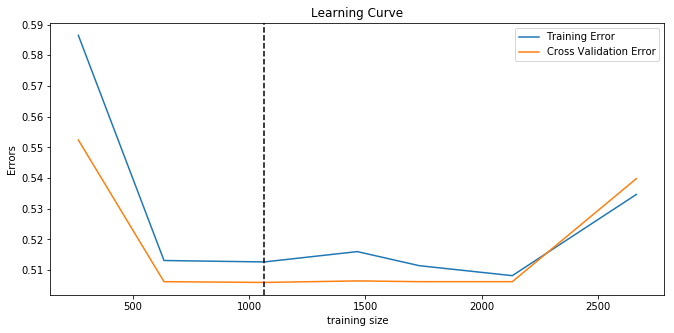

In [14]:
#Learning Curve 
clf = MLPClassifier(hidden_layer_sizes=(54,5,2),max_iter=500)
train_sizes, train_scores, test_scores = learning_curve(clf,X_train,y_train,train_sizes = np.array([0.1, 0.238, 0.4, 0.55, 0.65, 0.8, 1]),cv = 3)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.figure(figsize= (11,5))
plt.plot(train_sizes,1 -train_score_mean)
plt.plot(train_sizes,1 -test_score_mean)
plt.xlabel('training size')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.axvline(x=train_sizes[np.argmin(1 - np.array(test_score_mean))],color='k', linestyle='--')
plt.title('Learning Curve')
plt.show()

In [27]:
t1 = time.time()
# RandInd = np.random.choice(len(X_train),3000)
# Rtrain = X_train.iloc[RandInd,:]
# Rlabels = y_train.iloc[RandInd]
clf5 = MLPClassifier(hidden_layer_sizes=(54,5,2),max_iter=500)
# clf5.fit(Rtrain,Rlabels)
clf5.fit(X_train, y_train)
y_pred5 = clf5.predict(X_test)
t2 = time.time()
print('Running time: {}'.format(t2-t1))

Running time: 2.344200611114502


In [28]:
t1 = time.time()
print('Final accuracy score for Multi layer perceptron classifier : {}'.format(accuracy_score(y_test,y_pred5)))
t2 = time.time()
print('Running time: {}'.format(t2-t1))

Final accuracy score for Multi layer perceptron classifier : 0.495
Running time: 0.0007548332214355469
